In [ ]:
import warnings
import numpy as np
import os
import platform
import timeit

def data_download(file_to_download, gdrive_code, OS):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux":
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

data_download("./Garbage_Data_Set.zip", "1e0RJH5HLdRVmPnDaamQLn0WVYFz4gOrE", OS)

data_download("./Garbage_Libs.zip", "1ZoMU2QGYLKhIaGZS8y4IYvmHofeqvAMz", OS)

print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  4.992983013999947


In [ ]:
from Preprocessing.preprocessing import LoadData
from tensorflow.keras.utils import to_categorical

labels_garbage_list = ["glass", "metal", "paper", "plastic", "trash"]
limit = None
dest_input_size = 256

batch_size = 32

[x_train, y_train, x_val, y_val, x_test, y_test] = LoadData.load_dataset_cv('./Garbage_Data_Set', labels_garbage_list, 0.1, 0.1, True, limit, dest_input_size, True)
input_size = x_train.shape[1]
depth = x_train.shape[3]
classes = len(np.unique(y_train))

x_train = x_train / 255.0
x_test = x_test / 255.0 
x_val = x_val / 255.0

y_train = to_categorical(y_train, num_classes = classes)
y_val = to_categorical(y_val, num_classes = classes)
y_test = to_categorical(y_test, num_classes = classes)


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)



Loading time: 0.28 minutes

(1700, 256, 256, 3)
(1700, 5)
(212, 256, 256, 3)
(212, 5)
(212, 256, 256, 3)
(212, 5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,SGD

from tensorflow.keras.datasets import cifar10
import os
import tensorflow.keras as K
import tensorflow as tf

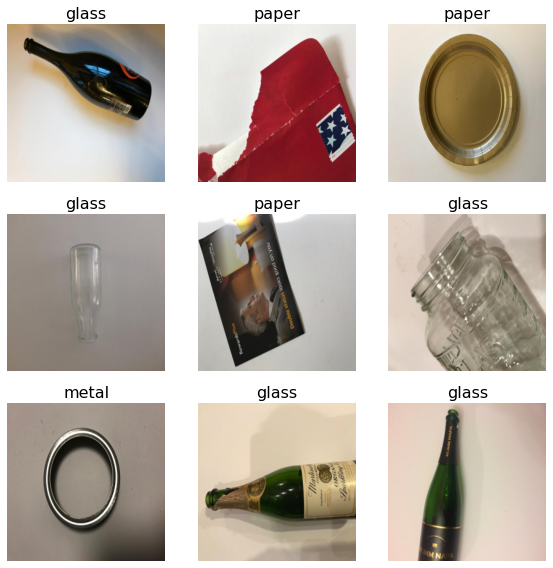

<Figure size 432x288 with 0 Axes>

In [ ]:
sp = 331
plt.figure(figsize=(8,8))
for i in range(9):
  color = 'black'
  plt.subplot(sp)
  plt.axis('off')
  plt.imshow(x_train[i])
  plt.title(labels_garbage_list[np.argmax(y_train[i])], fontsize=16, color=color)
  sp= sp +1
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

plt.tight_layout()

In [ ]:


adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.9999, decay=0.0)


checkPoint=ModelCheckpoint("./model.h5", save_weights_only=False, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlyStopping=EarlyStopping(monitor='val_loss', min_delta = 0.01, patience=15, verbose=0, mode='min') 
# lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=2.5e-5)
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, min_lr=1e-06, min_delta=0.01)

In [ ]:
shape = (256, 256, 3)
target_size = (256, 256)

input_tensor = K.Input(shape=shape)

def preprocess_data(X, Y):

    X = K.applications.resnet50.preprocess_input(X)
    Y = K.utils.to_categorical(Y, 10)
    
    return X, Y

def create_model():        
    # model_base = K.applications.ResNet101(include_top=False, weights="imagenet", input_tensor=input_tensor,input_shape=shape)
    # model_base = K.applications.NASNetLarge(include_top=False, weights="imagenet", input_tensor=input_tensor,input_shape=shape)
    # model_base = K.applications.MobileNetV3Large(include_top=False, weights="imagenet", 
    #                                              minimalistic = True,
    #                                              input_tensor=input_tensor,
    #                                              input_shape=shape)
    model_base = K.applications.MobileNet(include_top=False, weights="imagenet", input_tensor=input_tensor, input_shape=shape)
    model_base.trainable = False

    for i in range(10):
      model_base.layers[i].trainable = True

    model = K.models.Sequential(name='my_model')
    model.add(K.layers.Lambda(lambda image: tf.image.resize(image, target_size)))

    model.add(model_base)
    model.add(K.layers.Flatten())
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(5, activation='softmax'))  
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])

    return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model = create_model()
model.build((None, 256, 256, 3))
model.summary()


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dropout (Dropout)           (None, 65536)             0         
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 5)                 327

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)   # flip images horizontally

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
# validation_generator = validation_datagen.flow(x_val, y_val, batch_size=batch_size)

In [ ]:
history = model.fit(train_generator,    
                    validation_data=(x_val,y_val),
                    validation_steps=x_val.shape[0] / batch_size,
                    steps_per_epoch=x_train.shape[0] / batch_size,
                    epochs=50,
                    callbacks = [lrr,checkPoint,earlyStopping],
                    verbose=2)

# history = model.fit(x_train,y_train, validation_data = (x_val, y_val) ,
#                 epochs=50,
#                 steps_per_epoch = x_train.shape[0]/batch_size,
#                 batch_size=batch_size,
#                 callbacks = [lrr,checkPoint,earlyStopping],
#                 verbose=2)

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

index = np.argmax(history.history['val_accuracy'])

print('last model accuracy',history.history['val_accuracy'][-1])
print('best model accuracy',history.history['val_accuracy'][index])

# model = tf.keras.models.load_model('./model.h5') 
print('model accuracy on test data:',model.evaluate(x_test, y_test, batch_size=batch_size))


In [ ]:
[x_train, y_train, x_val, y_val, x_test, y_test] = LoadData.load_dataset_cv('./Garbage_Data_Set', labels_garbage_list, 0.1, 0.1, True, limit, dest_input_size, True)
input_size = x_train.shape[1]
depth = x_train.shape[3]
classes = len(np.unique(y_train))

x_train = x_train / 255.0
x_test = x_test / 255.0 
x_val = x_val / 255.0

y_train = to_categorical(y_train, num_classes = classes)
y_val = to_categorical(y_val, num_classes = classes)
y_test = to_categorical(y_test, num_classes = classes)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import seaborn as sns
import tensorflow.keras as K

labels = ["glass", "metal", "paper", "plastic", "trash"]
model = K.models.load_model('model.h5')
predictions = model.predict(x_test)

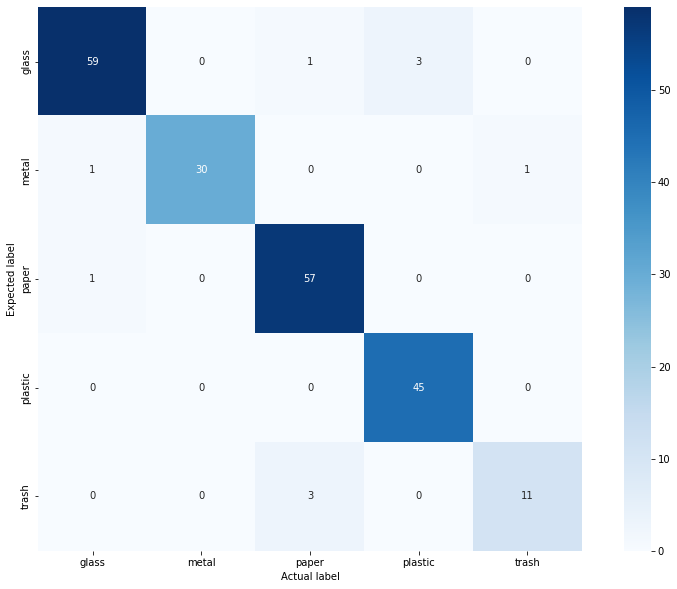

              precision    recall  f1-score   support

       glass       0.97      0.94      0.95        63
       metal       1.00      0.94      0.97        32
       paper       0.93      0.98      0.96        58
     plastic       0.94      1.00      0.97        45
       trash       0.92      0.79      0.85        14

    accuracy                           0.95       212
   macro avg       0.95      0.93      0.94       212
weighted avg       0.95      0.95      0.95       212



,predictions,actual_values
0,paper,paper
1,metal,metal
2,plastic,plastic
3,paper,paper
4,paper,paper


,predictions,actual_values
81,plastic,glass
82,paper,trash
88,plastic,glass
92,plastic,glass
98,paper,trash


n° of failing predictions: 10
accuracy: 0.9528301886792453


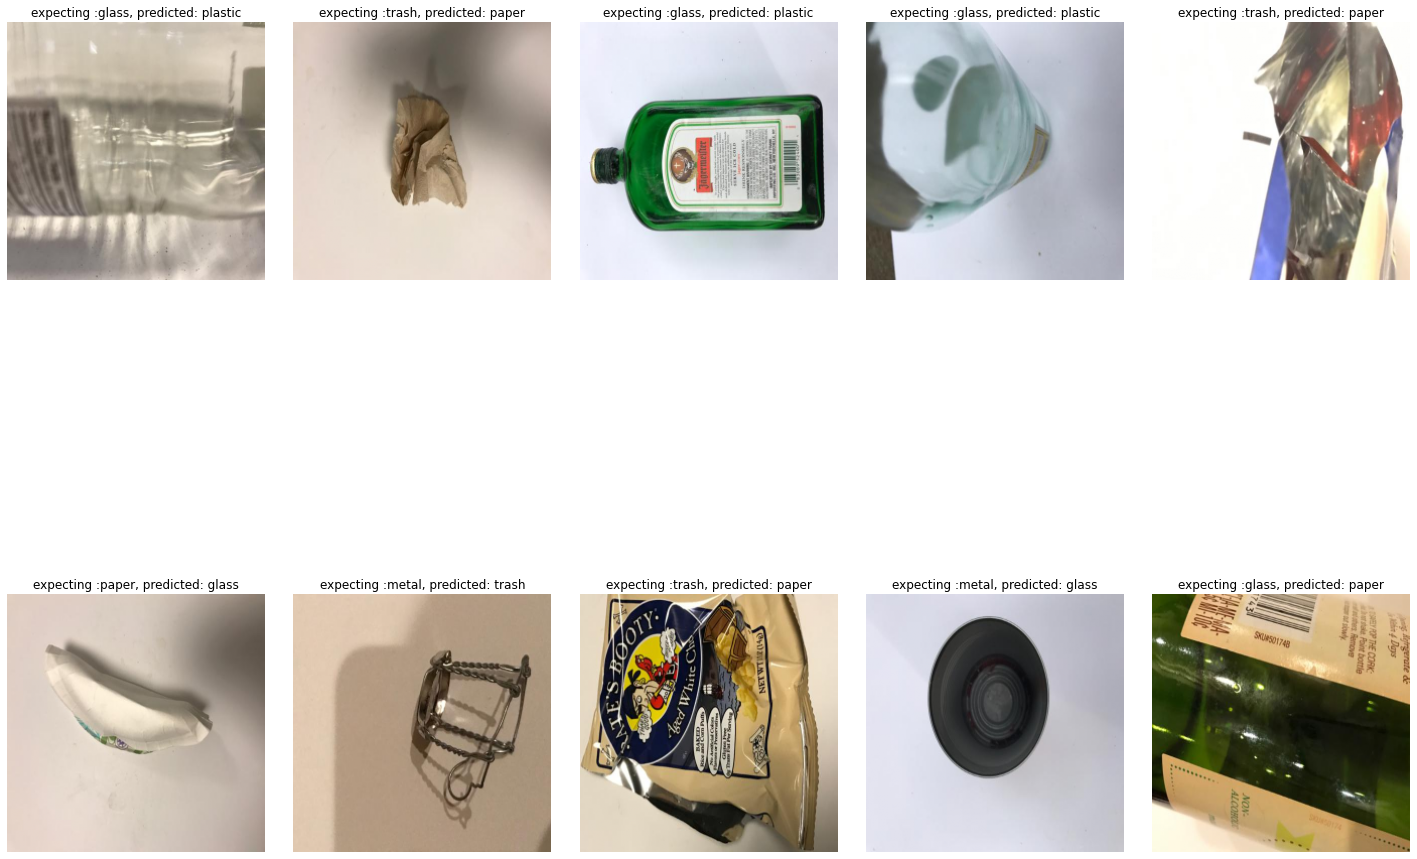

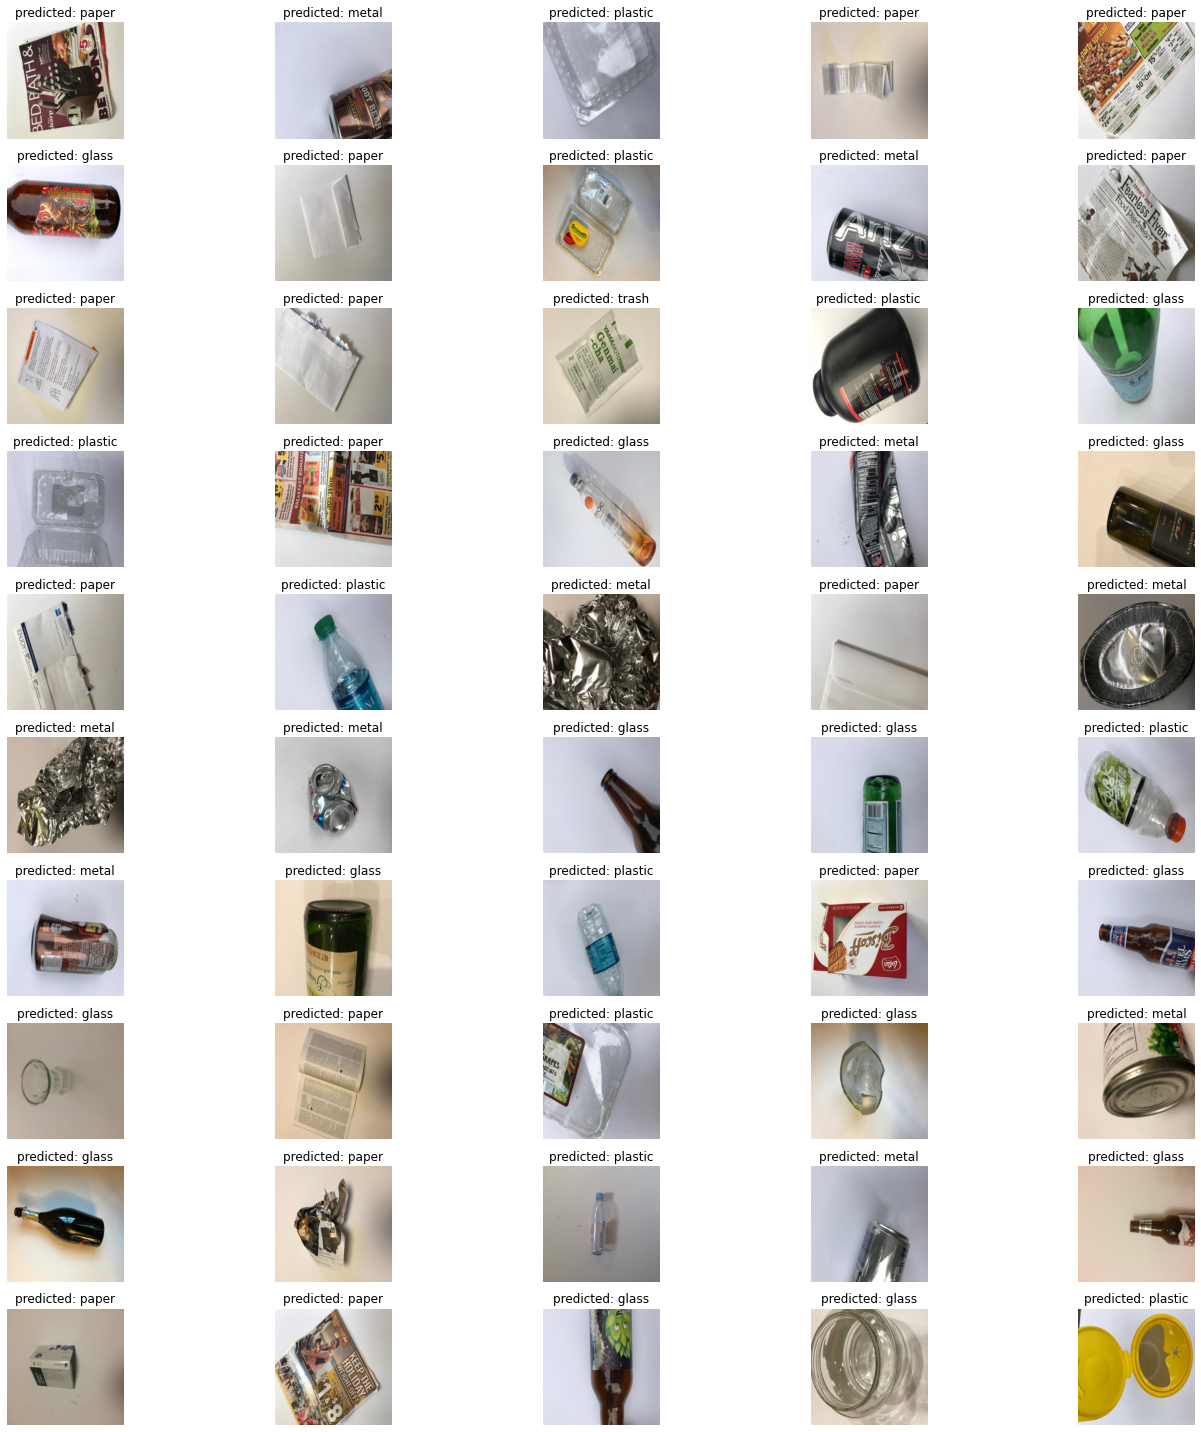

In [ ]:
df = pd.DataFrame(
    {'predictions':np.argmax(predictions,axis=1),
     'actual_values':np.argmax(y_test,axis=1)})

df['predictions']=df['predictions'].apply(lambda x: labels[x] )
df['actual_values']=df['actual_values'].apply(lambda x: labels[x] ) 

expected = df['predictions'].to_numpy()
actual = df['actual_values'].to_numpy()

# print(expected[:10])
# print(actual[:10])

cm=confusion_matrix(actual,expected)

plt.figure(figsize=[15, 10])
sns.heatmap(data=cm, annot=True, cmap='Blues', square=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Actual label')
plt.ylabel('Expected label')
plt.show()

print( classification_report(actual,expected))

display(df.head())

failings = df[df['predictions']!=df['actual_values']]
corrects = df[df['predictions']==df['actual_values']]

# print(len(failings))
display(failings.head())

failing_predictions = len(failings)

print('n° of failing predictions:',failing_predictions)
# print(failings.index[0])
total_data = len(df)

print('accuracy:',1 - failing_predictions / total_data)
# print('accuracy:',model.evaluate(X_test, y_test, batch_size=256))



fig = plt.figure(figsize=(20, 20))

columns = 5
rows = 2
total_pics = columns*rows
# print(failings.iloc[failings.index[0]])

for i in range(total_pics):
  if(i <total_pics):
    ax = fig.add_subplot(rows, columns, i+1)
  el = failings.iloc[i]
  ax.set_title('expecting :'+str(el.actual_values)+", predicted: "+str(el.predictions),fontsize=12)
  plt.imshow(x_test[failings.index[i]])
  plt.axis('off')
plt.tight_layout()

fig = plt.figure(figsize=(20, 20))

columns = 5
rows = 10
total_pics = columns*rows

for i in range(total_pics):
  if(i <total_pics):
    ax = fig.add_subplot(rows, columns, i+1)
  el = corrects.iloc[i]
  ax.set_title("predicted: "+str(el.predictions),fontsize=12)
  
  plt.imshow(x_test[corrects.index[i]])
  plt.axis('off')
plt.tight_layout()

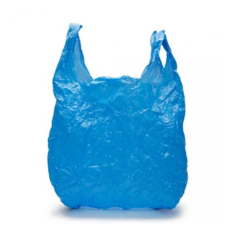

plastic


In [ ]:
from skimage import io
import matplotlib.pyplot as plt

url = 'https://tudelft.openresearch.net/image/2016/1/6/column_6_foto.jpg%28%29%28AF280C0D284815A074FE33A405BEE502%29.jpg'

image = io.imread(url)
plt.imshow(image)
plt.axis('off')
plt.show()
# print(image.shape)

# x = np.expand_dims([],[image])
# print(x.shape)

y = model.predict(np.array([image]))

index = np.argmax(y)

print(labels[index])


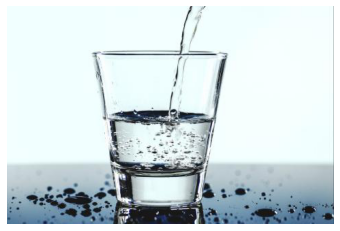

paper


In [ ]:
from skimage import io
import matplotlib.pyplot as plt

url = 'https://lingopolo.org/dutch/sites/lingopolo.org.dutch/files/styles/entry/public/images/2019/04/27/glass-3445987_1920.jpg?h=5b4b7360'

image = io.imread(url)
plt.imshow(image)
plt.axis('off')
plt.show()
# print(image.shape)

# x = np.expand_dims([],[image])
# print(x.shape)

y = model.predict(np.array([image]))

index = np.argmax(y)

print(labels[index])


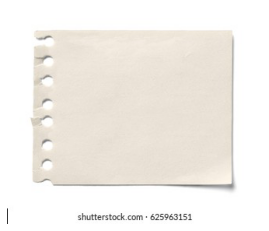

paper


In [ ]:
from skimage import io
import matplotlib.pyplot as plt

url = 'https://image.shutterstock.com/image-photo/close-vintage-note-paper-on-260nw-625963151.jpg'

image = io.imread(url)
plt.imshow(image)
plt.axis('off')
plt.show()
# print(image.shape)

# x = np.expand_dims([],[image])
# print(x.shape)

y = model.predict(np.array([image]))

index = np.argmax(y)

print(labels[index])
